In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
df_1 = pd.read_csv('Prices_BTC.csv', index_col='Date')

In [3]:
df_1.index = pd.to_datetime(df_1.index)

In [4]:
df_1

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2023-10-06,27412.123047,28252.537109,27215.552734,27946.597656,13492391599
2023-10-07,27946.781250,28028.091797,27870.423828,27968.839844,6553044316
2023-10-08,27971.677734,28102.169922,27740.662109,27935.089844,7916875290


In [5]:
#Split the dataset into trian and test

train_data_1, test_data_1 = df_1[:int(len(df_1)*0.9)], df_1[int(len(df_1)*0.9):]

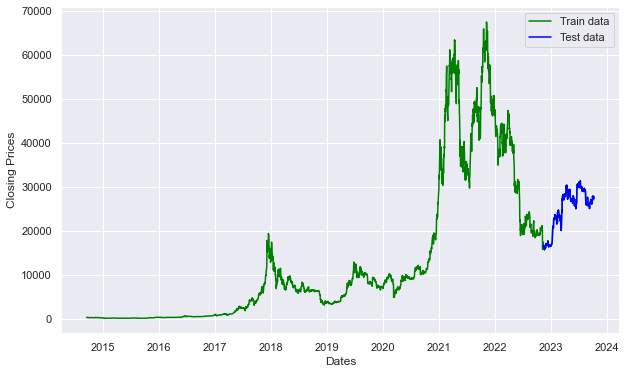

In [6]:
plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_1.Close, 'green', label='Train data')
plt.plot(test_data_1.Close, 'blue', label='Test data')
plt.legend()

******************************************************************************************************************************************************************************

## 1. ARIMA MODEL

In [7]:
from pmdarima.arima import auto_arima

In [8]:
arima_model = auto_arima(train_data_1['Close'], error_action='ignore', suppress_warnign=True, stepwise=False, approximation=False, seasonal=False)

In [9]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2979
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -24121.498
Date:                Fri, 27 Oct 2023   AIC                          48254.996
Time:                        12:21:56   BIC                          48290.990
Sample:                    09-17-2014   HQIC                         48267.947
                         - 11-12-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.5913     16.714      0.275      0.784     -28.167      37.349
ar.L1          0.8163      0.010     83.551      0.000       0.797       0.835
ar.L2         -0.9476      0.009   -103.952      0.000      -0.965      -0.930
ma.L1         -0.8470      0.010    -88.966      0.000      -0.866      -0.828
ma.L2          0.9571      0.009    109.606      0.000       0.940       0.974
sigma2      6.419e+05   5678.764    113.039      0.000    6.31e+05    6.53e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             33605.08
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):            2633.19   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
n_future = len(test_data_1)

In [11]:
arima_pred = arima_model.predict(n_periods=n_future, return_conf_int=True, alpha=0.05)

In [12]:
arima_pred = [pd.DataFrame(arima_pred[0], columns=['prediction']), pd.DataFrame(arima_pred[1], columns=['low_95', 'up_95'], index=arima_pred[0].index)]



In [13]:
arima_pred = pd.concat(arima_pred, axis=1)

In [14]:
arima_pred

,prediction,low_95,up_95
2022-11-13,16766.464128,15196.138679,18336.789577
2022-11-14,16876.032927,14689.044347,19063.021507
2022-11-15,17001.077725,14350.388551,19651.766899
2022-11-16,17003.919006,13946.630018,20061.207995
2022-11-17,16892.334664,13456.601851,20328.067476
...,...,...,...
2023-10-06,18217.685866,-9689.194301,46124.566034
2023-10-07,18221.759465,-9727.629872,46171.148802
2023-10-08,18225.811468,-9766.022794,46217.645730
2023-10-09,18229.850403,-9804.364860,46264.065666


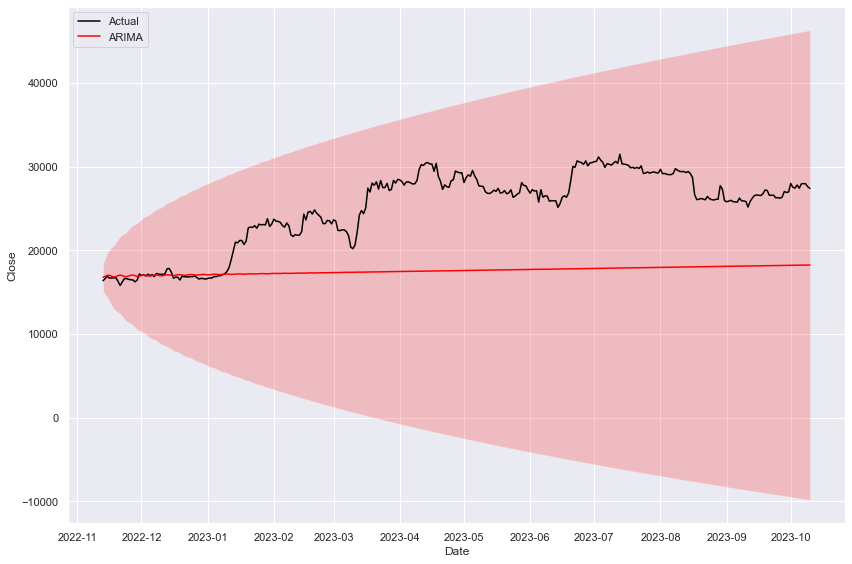

In [15]:
#Print results

fig, ax = plt.subplots(1, figsize=(12, 8))

ax = sns.lineplot(data=test_data_1['Close'], color='black', label= 'Actual')

ax.plot(arima_pred.prediction, color='red', label= 'ARIMA')

ax.fill_between(arima_pred.index, arima_pred.low_95, arima_pred.up_95, alpha=0.2, facecolor='red')

ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
# report performance
mse = mean_squared_error(test_data_1.Close, arima_pred.prediction)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_1.Close, arima_pred.prediction)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data_1.Close, arima_pred.prediction))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(arima_pred.prediction - test_data_1.Close)/np.abs(test_data_1.Close))
print('MAPE: '+str(mape))

MSE: 73105534.90164974
MAE: 7511.2067783035545
RMSE: 8550.17747778663
MAPE: 0.2764172399759155


******************************************************************************************************************************************************************************

## 2. XGBoots MODEL

In [17]:
import xgboost as xgb
from sklearn.model_selection import  GridSearchCV
from sklearn.model_selection import train_test_split

In [18]:
# Split the data in target and independant variables

x = df_1.drop(['Close'], axis = 1)

y = df_1['Close']

In [19]:
# Splitting to training and testing data

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, shuffle=False)

In [20]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

model = xgb.XGBRegressor( objective='reg:squarederror')
clf = GridSearchCV(model, parameters)

clf.fit(x_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.001, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
Best validation score = 0.025762143658920423
Wall time: 6min 12s


In [21]:
%%time

model_xgb = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model_xgb.fit(x_train, y_train)

Wall time: 295 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [22]:
y_pred = model_xgb.predict(x_test)

In [23]:
# Create dataframe

prediction = y_test.to_frame().copy()

In [24]:
# Model prediction on test data

prediction['y_predr'] = y_pred

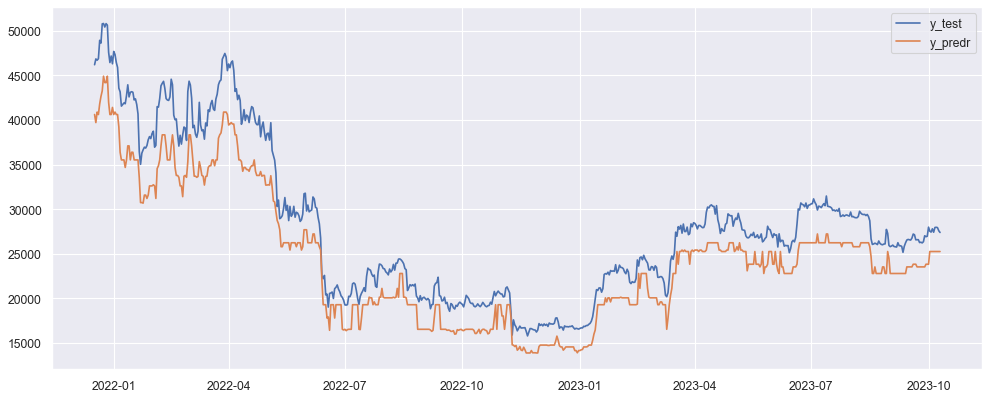

In [25]:
figure(figsize=(15, 6), dpi=80)

plt.plot(prediction['Close'], label='y_test')
plt.plot(prediction['y_predr'], label='y_predr')
plt.legend()
plt.show()

In [26]:
# report performance
mse = mean_squared_error(prediction['Close'], prediction['y_predr'])
print('MSE: '+str(mse))
mae = mean_absolute_error(prediction['Close'], prediction['y_predr'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(prediction['Close'],prediction['y_predr']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(prediction['y_predr'] - prediction['Close'])/np.abs(prediction['Close']))
print('MAPE: '+str(mape))

MSE: 14679766.988405295
MAE: 3539.6522966157618
RMSE: 3831.418404247348
MAPE: 0.12616460516653452


******************************************************************************************************************************************************************************

## 3. Long Short Term Memory (LSTM)

In [27]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU,LSTM, Dropout

In [28]:
#Scale train data

scaler = MinMaxScaler()
scaler = scaler.fit(df_1)
scaled_data = scaler.transform(df_1)

In [29]:
scaled_data

array([[4.28907289e-03, 3.73944129e-03, 4.24270742e-03, 4.14358659e-03,
        4.31449241e-05],
       [4.15542811e-03, 3.57446064e-03, 3.64887469e-03, 3.65546321e-03,
        8.14009147e-05],
       [3.66922343e-03, 3.15121938e-03, 3.21734241e-03, 3.21556748e-03,
        9.11925723e-05],
       ...,
       [4.12551732e-01, 4.06697221e-01, 4.16386076e-01, 4.11893633e-01,
        2.25407882e-02],
       [4.11999505e-01, 4.05053846e-01, 4.09769311e-01, 4.06678932e-01,
        3.41967309e-02],
       [4.06874717e-01, 4.01063886e-01, 4.09755594e-01, 4.03820023e-01,
        2.84003264e-02]])

In [30]:
# Ya que el modelo LSTM alamcena memoria a largo plazo, creamos una extructura de 14 periodos.
# Por lo que, para cada elemento de grupo de entrenamiento, se usan los 14 anteriores datos.
# Basicamente cogemos los primeros 14 periodos para calcular el 15.

def X_y (df, window_size):
    
    X=[]
    y=[]
    
    for i in range(len(scaled_data)-window_size):
        row = [a for a in scaled_data[i:i+window_size]]    
        X.append(row)
        label = scaled_data[i+window_size][3]       # Columna del precio de cierre
        y.append(label)
        
    return np.array(X), np.array(y)

In [31]:
X, y = X_y(scaled_data, window_size=14)

X.shape, y.shape

((3297, 14, 5), (3297,))

In [32]:
X_train, y_train = X[:int(X.shape[0]*0.9)], y[:int(X.shape[0]*0.9)]
X_val, y_val = X[int(X.shape[0]*0.9):int(X.shape[0]*0.95)], y[int(X.shape[0]*0.9):int(X.shape[0]*0.95)]
X_test, y_test = X[int(X.shape[0]*0.95):], y[int(X.shape[0]*0.95):]

In [33]:
model2 = Sequential()

model2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(units=50, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=50))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 14, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 14, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [34]:
model2.compile(tf.keras.optimizers.Adam(learning_rate=0.01), 
               loss=tf.keras.losses.MeanSquaredError())

In [35]:
history2 = model2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val) )

Epoch 1/10
93/93 [==============================] - 8s 18ms/step - loss: 0.0065 - val_loss: 4.3249e-04
Epoch 2/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 3.4231e-04
Epoch 3/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 7.7730e-04
Epoch 4/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 9.4254e-04
Epoch 5/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 4.5428e-04
Epoch 6/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 9.5025e-04
Epoch 7/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 8/10
93/93 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 9/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 10/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 

In [36]:
predictions2 = model2.predict(X_test).flatten()
df2 = pd.DataFrame(data={'Predictions':predictions2, 'Real': y_test})
df2

6/6 [==============================] - 1s 3ms/step


,Predictions,Real
0,0.418516,0.431384
1,0.423334,0.431685
2,0.423920,0.414216
3,0.417252,0.422956
4,0.409233,0.427790
...,...,...
160,0.393915,0.412064
161,0.394377,0.412394
162,0.396925,0.411894
163,0.399270,0.406679


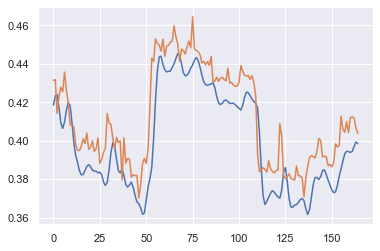

In [37]:
start = 0
end = X_test.shape[0]

plt.plot(df2.Predictions[start:end])
plt.plot(df2.Real[start:end])

In [38]:
# report performance
mse = mean_squared_error(df2['Real'], df2['Predictions'])
print('MSE: '+str(mse))
mae = mean_absolute_error(df2['Real'], df2['Predictions'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(df2['Real'],df2['Predictions']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(df2['Predictions'] - df2['Real'])/np.abs(df2['Real']))
print('MAPE: '+str(mape))

MSE: 0.00024700932581416316
MAE: 0.013431371351497433
RMSE: 0.015716530336373966
MAPE: 0.03269738439317129


******************************************************************************************************************************************************************************

## 4. Gated Recurrent Network (GRU)

In [39]:
model1 = Sequential()

model1.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model1.add(Dropout(0.2))
model1.add(GRU(units=50, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(GRU(units=50))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 50)            8550      
                                                                 
 dropout_3 (Dropout)         (None, 14, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 14, 50)            15300     
                                                                 
 dropout_4 (Dropout)         (None, 14, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [40]:
model1.compile(tf.keras.optimizers.Adam(learning_rate=0.01), 
               loss=tf.keras.losses.MeanSquaredError())

In [41]:
history1 = model1.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val) )

Epoch 1/10
93/93 [==============================] - 6s 17ms/step - loss: 0.0111 - val_loss: 5.2944e-04
Epoch 2/10
93/93 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 3/10
93/93 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 3.6133e-04
Epoch 4/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 2.4745e-04
Epoch 6/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 1.8757e-04
Epoch 7/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 3.3438e-04
Epoch 8/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 9/10
93/93 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 1.9283e-04
Epoch 10/10
93/93 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss

In [42]:
predictions = model1.predict(X_test).flatten()
df = pd.DataFrame(data={'Predictions':predictions, 'Real': y_test})
df

6/6 [==============================] - 1s 0s/step


,Predictions,Real
0,0.432322,0.431384
1,0.435843,0.431685
2,0.438086,0.414216
3,0.432841,0.422956
4,0.431356,0.427790
...,...,...
160,0.411876,0.412064
161,0.413310,0.412394
162,0.416222,0.411894
163,0.417700,0.406679


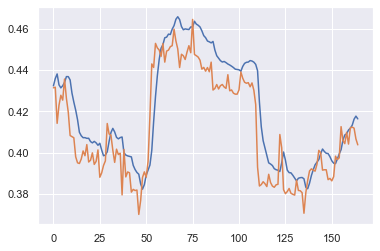

In [43]:
start = 0
end = X_test.shape[0]

plt.plot(df.Predictions[start:end])
plt.plot(df.Real[start:end])

In [44]:
    
# report performance
mse = mean_squared_error(df['Real'], df['Predictions'])
print('MSE: '+str(mse))
mae = mean_absolute_error(df['Real'], df['Predictions'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(df['Real'],df['Predictions']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(df['Predictions'] - df['Real'])/np.abs(df['Real']))
print('MAPE: '+str(mape))

MSE: 0.0001749947982866376
MAE: 0.010747045067013105
RMSE: 0.013228559947576969
MAPE: 0.026145001188000595


******************************************************************************************************************************************************************************